# Install the needed packages

%pip install datasets
%pip install transformers
%pip install sentencepiece
%pip install diffusers --upgrade
%pip install invisible_watermark accelerate safetensors
%pip install accelerate
%pip install jiwer
%pip install evaluate

In [1]:
import pandas as pd
import datasets
import torch
import torch.nn as nn
from transformers import AutoProcessor,TrainingArguments, Trainer
from transformers import AutoModelForCausalLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# Load the dataset

We check if the dataset is already present in the system, by checking the local variables. If it is not present we load it, else we just skip it. This is done to avoid loading the dataset again and again, as it takes time to load the dataset.

## Data to Keep
Since in this notebook we only Fine-Tune the Captioning model we only keep the descriptions of the paintings, which we scraped from the urls provided in the original dataset.

In [2]:
if 'data' not in locals():
    data = pd.read_csv('../described_dataset_label.csv',sep='\t',encoding='latin-1')
    data = data.iloc[:2000]
    data = data.rename(columns={'FILE':'image','AUTHOR':'author', 'TITLE': 'title', 'TECHNIQUE':'style','URL':'description'})
    data = data[['image','description']]
    data['image'] = [f'.{x}' for x in data['image']]
data.head()

,image,description
0,../images/1.jpg,"The painting, displaying the characteristic Ma..."
1,../images/2.jpg,The representation of this group is related to...
2,../images/3.jpg,At the end of the 16th century the court of Em...
3,../images/4.jpg,Rudolf II (1552-1612) was the son of the Holy ...
4,../images/5.jpg,Hans von Aachen was an artist who fully embrac...


In [3]:
print(data.columns)

Index(['image', 'description'], dtype='object')


In [4]:
dataset = datasets.Dataset.from_pandas(data).cast_column('image',datasets.Image())
print(dataset)

Dataset({
    features: ['image', 'description'],
    num_rows: 2000
})


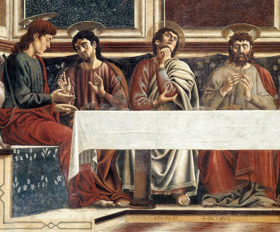

In [5]:
sample = dataset[413]

image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))
caption = sample['description']

# The Model

For our task, we opted for the Git-large-Coco model provided by Microsoft. This model is a large-scale language model trained on the Coco dataset, which shares similarities with our dataset as it consists of images paired with textual descriptions. Among the models available on Hugging Face, we found that the Git-large-Coco model consistently yielded superior results for our specific task.

In addition to the model itself, we utilized the associated processor. This processor aligns with the one used during the original training of the model. Ensuring consistency between the model and its processor is crucial, as the processor plays a key role in tokenizing input data. Mismatched processors could result in the model being unable to interpret input data correctly. By leveraging the pre-existing processor, we save significant time and effort that would otherwise be required to develop and fine-tune our own processor.


In [6]:
checkpoint_capt= "microsoft/git-large-coco"
processor_capt = AutoProcessor.from_pretrained(checkpoint_capt)

# Data Preprocessing

To facilitate data feeding into the processor and obtain tokenized inputs for the model, we define a function named `capt_transforms`. This function transforms the raw data into a format suitable for the model input. Here's a breakdown of the process:

## Function Description
The `capt_transforms` function takes an example batch containing images and captions as input. It performs the following steps:

1. **Extract Images and Captions**:
   - Extracts images and captions from the example batch.

2. **Tokenization**:
   - Utilizes the pre-trained processor (`processor_capt`) to tokenize the images and captions.
   - Sets the maximum sequence length for padding and truncates sequences if needed.
   - Returns a DatasetDict containing tokenized inputs with keys "input_ids" and "labels".

## Input and Output
- **Input**: Example batch containing images and captions.
- **Output**: Tokenized inputs suitable for model ingestion, comprising input IDs and corresponding labels.

## Data Processing Improvements
- **Efficient Transformation**: The function efficiently transforms raw data into tokenized inputs using the pre-trained processor, ensuring compatibility with the model's input requirements.
- **Padding and Truncation**: Utilizes padding and truncation to handle sequences of varying lengths, enabling uniform input sizes for the model.
- **Label Generation**: Generates labels from input IDs, facilitating model training and evaluation.

By employing this data preprocessing function, we streamline the pipeline for preparing inputs to the model, ultimately enhancing efficiency and compatibility with downstream tasks.


In [7]:
def capt_transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["description"]]
    inputs = processor_capt(images=images, text=captions, padding="max_length", truncation=True)
    inputs.update({"labels": inputs["input_ids"]})
    return inputs

In [8]:
#Caption
capt_dataset = dataset.train_test_split(test_size=0.3)
capt_dataset = capt_dataset.with_transform(capt_transforms)

In [9]:
model_capt = AutoModelForCausalLM.from_pretrained(checkpoint_capt)
model_capt = model_capt.to(device)

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


As an optimizer we use AdamW with a learning rate of 1e-4, which is a common learning rate for fine-tuning models. We also use the CrossEntropyLoss, which computes the crossentropy loss between the obtained captions and the labels.

In [10]:
git_optimizer = torch.optim.AdamW(model_capt.parameters(),lr=5e-5)
git_criterion = nn.CrossEntropyLoss()

We decided to fine tune the model for 70 epochs, which we found to be a good number to get good results, without overfitting the model.

In [11]:
num_epochs_capt = 50
torch.cuda.empty_cache()

In [12]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

# Evaluation

In assessing the performance of our model, we employed the Bleu score, a widely used metric for evaluating image captioning in generative models. The Bleu score measures the similarity between generated captions and ground truth captions by comparing n-grams, thereby providing insights into the quality and accuracy of the generated captions.

To compute the Bleu score, we utilized the load_metric function from the datasets library, specifically loading the Bleu metric for evaluation purposes.
We then defined a custom function named capt_compute_metrics to compute the Bleu score for evaluation. This function takes eval_pred as input, which contains logits (model predictions) and labels (ground truth captions).

The function performs the following steps:

1. Extracts logits (model predictions) and labels (ground truth captions) from the eval_pred input.
2. Decodes the labels and predictions using the associated processor (processor_capt), skipping special tokens to obtain human-readable text.
3. Computes the Bleu score using the decoded predictions and references (ground truth captions).
4. Returns a dictionary containing the computed Bleu score under the key "bleu_score".

By utilizing the Bleu score and implementing a custom evaluation function, we gain valuable insights into the quality of our model's generated captions compared to ground truth captions. This facilitates quantitative assessment and refinement of the model's performance, ultimately contributing to its effectiveness in generating accurate and relevant captions for images.


In [13]:
# from evaluate import load
# import torch

# wer = load("wer")
from datasets import load_metric

bleu = load_metric("bleu")

def capt_compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor_capt.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor_capt.batch_decode(predicted, skip_special_tokens=True)
    wer_score = bleu.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

C:\Users\Fede\AppData\Local\Temp\ipykernel_21452\313036895.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu = load_metric("bleu")


# Fine tuning

In this notebook we decide to use the HuggingFace trainer since it is a very easy to use and powerful tool to fine-tune models. This saved us time in writing our own custom training loop as the hugging face model serves us as a comparison for our custom models, which we train in a different notebook.

In [14]:
torch.cuda.empty_cache()
capt_training_args = TrainingArguments(
    output_dir="model_checkpoints/captioning",
    learning_rate=5e-5,
    num_train_epochs=num_epochs_capt,
    fp16=False,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8 ,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="no",
    save_strategy="no",
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

capt_trainer = Trainer(
    model=model_capt,
    args=capt_training_args,
    data_collator=data_collator,
    train_dataset=capt_dataset["train"],
    eval_dataset=capt_dataset["test"],
    compute_metrics=capt_compute_metrics,
)
torch.cuda.empty_cache() 
capt_trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rullofederico16 (fede-). Use `wandb login --relogin` to force relogin


  0%|          | 0/4350 [00:00<?, ?it/s]

{'loss': 1.4796, 'learning_rate': 4.4252873563218394e-05, 'epoch': 5.71}
{'loss': 0.4946, 'learning_rate': 3.850574712643678e-05, 'epoch': 11.43}
{'loss': 0.2923, 'learning_rate': 3.275862068965517e-05, 'epoch': 17.14}
{'loss': 0.1665, 'learning_rate': 2.7011494252873566e-05, 'epoch': 22.86}
{'loss': 0.0974, 'learning_rate': 2.1264367816091954e-05, 'epoch': 28.57}
{'loss': 0.0619, 'learning_rate': 1.5517241379310346e-05, 'epoch': 34.29}
{'loss': 0.0434, 'learning_rate': 9.770114942528738e-06, 'epoch': 40.0}
{'loss': 0.0335, 'learning_rate': 4.022988505747127e-06, 'epoch': 45.71}
{'train_runtime': 31752.1731, 'train_samples_per_second': 2.205, 'train_steps_per_second': 0.137, 'train_loss': 0.3092108741847948, 'epoch': 49.71}


TrainOutput(global_step=4350, training_loss=0.3092108741847948, metrics={'train_runtime': 31752.1731, 'train_samples_per_second': 2.205, 'train_steps_per_second': 0.137, 'train_loss': 0.3092108741847948, 'epoch': 49.71})

We save the model to be able to use it externally to the notebook and be also able to do our comparison.

In [15]:
capt_trainer.save_model("./model_checkpoints/captioning")

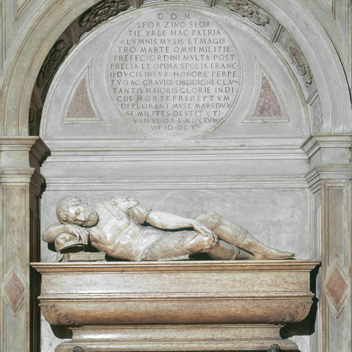

Description: Gian Francesco Ferrari d'Agrate worked on the monument to Sforzino Sforza together with his brother Marco d'Agrate (c. 1504-c. 1574). They came from a Lombard family of sculptors.


In [16]:
sample = dataset[123]
image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))
desc = sample['description']
print(f'Description: {desc}')

In [17]:
inputs = processor_capt(images = image, return_tensors='pt').to(device)
pixel_values = inputs.pixel_values

generated_ids = model_capt.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor_capt.batch_decode(generated_ids,skip_special_tokens=True)[0]
print(generated_caption)

gian francesco ferrari d'agrate worked on the monument to sforzino sforza together with his brother marco d'agrate ( c. 1504 - c. 1571 ). they came from a lombard family of sculptors


# Project Work, Image generation

In [19]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to(device)

prompt = generated_caption

images = pipe(prompt=prompt).images[0]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\diffusers\models\attention_processor.py:1244: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(


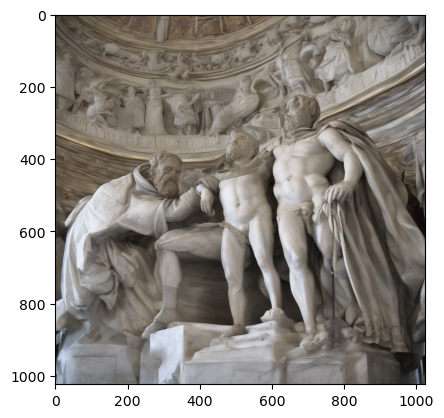

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgplot = plt.imshow(images)
plt.show()